# Single Predictor Against entire Wavelength (multiple nPCs)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression

import optuna

from sklearn.decomposition import PCA

from tqdm import tqdm

# load the data

## load matrices

In [2]:
# TiTE
all_data = {}
all_data["Ti_TE"] = pd.read_excel("../p04_TE_TM_1D_compare/Ti_TE_matrix.xlsx", header=None).transpose()
all_data["Ti_TE"].columns = [f"feature_{i+1}" for i in range(all_data["Ti_TE"].shape[1])]
all_data["Ti_TE"]["target"] = list(range(1, all_data["Ti_TE"].shape[0] + 1))

In [3]:
for dat in ["Si_TE", "Si_TM", "Ti_TM"]:
    all_data[dat] = pd.read_excel(f"./{dat}_matrix.xlsx", header=None).transpose()
    all_data[dat].columns = [f"feature_{i+1}" for i in range(all_data[dat].shape[1])]
    all_data[dat]["target"] = list(range(1, all_data[dat].shape[0] + 1))

# build the 5-fold cross validation groups and construct PCs

In [4]:
# split the data into 5-folds cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=19890417)
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
PC_folds = {}
folds = {} # this will not use PC to reduce the data

for dat in all_data.keys():
    PC_folds[dat] = []
    folds[dat] = []
    full_data = all_data[dat].copy()
    for train_index, test_index in kf.split(all_data[dat]):
        # because this doesn't check for out of range values we need to make sure that we move any 0 or 100 index values from test to train
        # if 0 in test_index:
        #     test_index = np.delete(test_index, np.where(test_index == 0)[0][0])
        #     train_index = np.append(train_index, 0)
        # if 100 in test_index:
        #     test_index = np.delete(test_index, np.where(test_index == 100)[0][0])
        #     train_index = np.append(train_index, 100)
        # train_index.sort()
        # print(f"train: {train_index}, test: {test_index}")
        train_data = full_data.iloc[train_index]
        test_data = full_data.iloc[test_index]
        # first put the raw data into the folds
        folds[dat].append((train_data.drop(columns=["target"]), train_data["target"].values, test_data.drop(columns=["target"]), test_data["target"].values))
        # now we also want to dimensionally reduce the data into 80 PCs following the training data
        pca = PCA(n_components=80, svd_solver='full', random_state=19890417)
        # first standardize the data according to the training data
        scaler = StandardScaler()
        scaler.fit(train_data.drop(columns=["target"]))
        train_data_scaled = scaler.transform(train_data.drop(columns=["target"]))
        test_data_scaled = scaler.transform(test_data.drop(columns=["target"]))
        pca.fit(train_data_scaled)
        train_data_pca = pca.transform(train_data_scaled)
        test_data_pca = pca.transform(test_data_scaled)
        PC_folds[dat].append((train_data_pca, train_data["target"].values, test_data_pca, test_data["target"].values))

# Identify best single variate performer for each dataset

In [5]:
results_dfs = {}
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    result_list = []
    fold_i = 0
    for train_data_pca, train_target, test_data_pca, test_target in folds[dat]:
        for feat_i in tqdm(range(train_data_pca.shape[1])):
            X_train = train_data_pca[f"feature_{feat_i+1}"].to_numpy()
            y_train = train_target
            X_test = test_data_pca[f"feature_{feat_i+1}"].to_numpy()
            y_test = test_target
            # Fit a linear regression model
            model = LinearRegression()
            model.fit(X_train.reshape(-1, 1), y_train)
            # Make predictions
            y_pred = model.predict(X_test.reshape(-1, 1))
            # Calculate MSE, R2, RMSE, MAE
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(y_test - y_pred))
            # now calculate the same metrics on the training data
            y_train_pred = model.predict(X_train.reshape(-1, 1))
            mse_train = mean_squared_error(y_train, y_train_pred)
            r2_train = r2_score(y_train, y_train_pred)
            rmse_train = np.sqrt(mse_train)
            mae_train = np.mean(np.abs(y_train - y_train_pred))
            # Append results to the list
            result_list.append({
                "feature": f"feature_{feat_i+1}",
                "mse": mse,
                "r2": r2,
                "rmse": rmse,
                "mae": mae,
                "fold": fold_i,
                "mse.train": mse_train,
                "r2.train": r2_train,
                "rmse.train": rmse_train,
                "mae.train": mae_train,
            })
        fold_i += 1
    results_dfs[dat] = pd.DataFrame(result_list)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:18<00:00, 534.03it/s]


In [6]:
# for each dataset we want to print the mean and std of the metrics for the best feature
# also save them to a lookup table
best_results = {}
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    print(f"Dataset: {dat}")
    # first group by feature to find the feature with lowest mean mse
    mean_results = results_dfs[dat].groupby("feature").agg({
        "mse": ["mean","std"],
        "r2": ["mean","std"],
        "rmse": ["mean","std"],
        "mae": ["mean","std"],
        "mse.train": ["mean","std"],
        "r2.train": ["mean","std"],
        "rmse.train": ["mean","std"],
        "mae.train": ["mean","std"],
    })
    mean_results.columns = ["_".join(col).strip() for col in mean_results.columns.values]
    mean_results = mean_results.reset_index()
    # now we want to find the feature with the lowest mean mse for training
    best_feature_idx = mean_results["mse.train_mean"].idxmin()
    best_feature = mean_results.iloc[best_feature_idx]
    print(f"Best feature: {best_feature['feature']} (train MSE: {best_feature['mse.train_mean']:.4f} std ({best_feature['mse.train_std']:.4f}))")
    print(f"Mean MSE: {best_feature['mse_mean']:.4f} std ({best_feature['mse_std']:.4f})")
    print(f"Mean R2: {best_feature['r2_mean']:.4f} std ({best_feature['r2_std']:.4f})")
    print(f"Mean RMSE: {best_feature['rmse_mean']:.4f} std ({best_feature['rmse_std']:.4f})")
    print(f"Mean MAE: {best_feature['mae_mean']:.4f} std ({best_feature['mae_std']:.4f})")
    print()
    # save the best feature to the lookup table
    best_results[dat] = {
        "feature": best_feature["feature"],
        "mse_mean": best_feature["mse_mean"],
        "mse_std": best_feature["mse_std"],
        "r2_mean": best_feature["r2_mean"],
        "r2_std": best_feature["r2_std"],
        "rmse_mean": best_feature["rmse_mean"],
        "rmse_std": best_feature["rmse_std"],
        "mae_mean": best_feature["mae_mean"],
        "mae_std": best_feature["mae_std"],
        "mse.train_mean": best_feature["mse.train_mean"],
        "mse.train_std": best_feature["mse.train_std"], 
        "r2.train_mean": best_feature["r2.train_mean"],
        "r2.train_std": best_feature["r2.train_std"],
        "rmse.train_mean": best_feature["rmse.train_mean"],
        "rmse.train_std": best_feature["rmse.train_std"],
        "mae.train_mean": best_feature["mae.train_mean"],
        "mae.train_std": best_feature["mae.train_std"],
    }

Dataset: Ti_TM
Best feature: feature_5094 (train MSE: 0.4017 std (0.0247))
Mean MSE: 0.4462 std (0.1050)
Mean R2: 0.9994 std (0.0002)
Mean RMSE: 0.6636 std (0.0855)
Mean MAE: 0.5234 std (0.0653)

Dataset: Ti_TE
Best feature: feature_4956 (train MSE: 0.0628 std (0.0038))
Mean MSE: 0.0655 std (0.0150)
Mean R2: 0.9999 std (0.0000)
Mean RMSE: 0.2547 std (0.0284)
Mean MAE: 0.2151 std (0.0306)

Dataset: Si_TE
Best feature: feature_390 (train MSE: 0.2336 std (0.0204))
Mean MSE: 0.2416 std (0.0866)
Mean R2: 0.9997 std (0.0001)
Mean RMSE: 0.4853 std (0.0873)
Mean MAE: 0.4001 std (0.0558)

Dataset: Si_TM
Best feature: feature_1206 (train MSE: 0.1355 std (0.0089))
Mean MSE: 0.1417 std (0.0378)
Mean R2: 0.9998 std (0.0001)
Mean RMSE: 0.3736 std (0.0509)
Mean MAE: 0.3097 std (0.0525)



# Now Evaluate the performance when the entire peak is used

In [27]:
results_entire_wave_dfs = {}
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    result_list = []
    fold_i = 0
    for train_data_pca, train_target, test_data_pca, test_target in PC_folds[dat]:
        # now we want to use the entire wave data
        # Fit a linear regression model
        model = LinearRegression()
        model.fit(train_data_pca, train_target)
        # Make predictions
        y_pred = model.predict(test_data_pca)
        # Calculate MSE, R2, RMSE, MAE
        mse = mean_squared_error(test_target, y_pred)
        r2 = r2_score(test_target, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(test_target - y_pred))
        # Append results to the list
        result_list.append({
            "mse": mse,
            "r2": r2,
            "rmse": rmse,
            "mae": mae,
            "fold": fold_i,
        })
        fold_i += 1
    results_entire_wave_dfs[dat] = pd.DataFrame(result_list)

# for each dataset we want to print the mean and std of the metrics for the best feature
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    print(f"Dataset: {dat}")
    # first group by feature to find the feature with lowest mean mse
    mean_results = results_entire_wave_dfs[dat].agg({
        "mse": ["mean","std"],
        "r2": ["mean","std"],
        "rmse": ["mean","std"],
        "mae": ["mean","std"],
    })
    # mean_results.columns = ["_".join(col).strip() for col in mean_results.columns.values]
    
    # just print the mean and std
    # calculate the fold improvement for mse compared to the best feature
    fold_improvement = (mean_results["mse"].values[0] / best_results[dat]["mse_mean"])**-1
    print(f"Mean MSE: {mean_results['mse'].values[0]:.4e} std ({mean_results['mse'].values[1]:.4e}). {fold_improvement:.2f}x fold improvement")
    fold_improvement = (mean_results["r2"].values[0] / best_results[dat]["r2_mean"])**-1
    print(f"Mean R2: {mean_results['r2'].values[0]:.4f} std ({mean_results['r2'].values[1]:.4f}). {fold_improvement:.2f}x fold improvement")
    fold_improvement = (mean_results["rmse"].values[0] / best_results[dat]["rmse_mean"])**-1
    print(f"Mean RMSE: {mean_results['rmse'].values[0]:.4f} std ({mean_results['rmse'].values[1]:.4f}). {fold_improvement:.2f}x fold improvement")
    fold_improvement = (mean_results["mae"].values[0] / best_results[dat]["mae_mean"])**-1
    print(f"Mean MAE: {mean_results['mae'].values[0]:.4f} std ({mean_results['mae'].values[1]:.4f}). {fold_improvement:.2f}x fold improvement")
    print()

Dataset: Ti_TM
Mean MSE: 6.6233e-05 std (2.1992e-05). 6736.42x fold improvement
Mean R2: 1.0000 std (0.0000). 1.00x fold improvement
Mean RMSE: 0.0080 std (0.0014). 82.52x fold improvement
Mean MAE: 0.0066 std (0.0010). 79.74x fold improvement

Dataset: Ti_TE
Mean MSE: 1.0488e-04 std (6.4012e-05). 624.73x fold improvement
Mean R2: 1.0000 std (0.0000). 1.00x fold improvement
Mean RMSE: 0.0099 std (0.0031). 25.82x fold improvement
Mean MAE: 0.0072 std (0.0016). 29.84x fold improvement

Dataset: Si_TE
Mean MSE: 2.4732e-02 std (9.9685e-03). 9.77x fold improvement
Mean R2: 1.0000 std (0.0000). 1.00x fold improvement
Mean RMSE: 0.1547 std (0.0314). 3.14x fold improvement
Mean MAE: 0.1257 std (0.0288). 3.18x fold improvement

Dataset: Si_TM
Mean MSE: 1.0345e-01 std (2.1553e-01). 1.37x fold improvement
Mean R2: 0.9999 std (0.0003). 1.00x fold improvement
Mean RMSE: 0.2035 std (0.2785). 1.84x fold improvement
Mean MAE: 0.0871 std (0.0670). 3.56x fold improvement



# try different numbers of PCs

In [15]:
nPCs_results_dfs = {}
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    result_list = []
    fold_i = 0
    for train_data_pca, train_target, test_data_pca, test_target in PC_folds[dat]:
        for nPCs in tqdm(range(1, 81)):
            # now we want to use the entire wave data
            # Fit a linear regression model
            model = LinearRegression()
            model.fit(train_data_pca[:, :nPCs], train_target)
            # Make predictions
            y_pred = model.predict(test_data_pca[:, :nPCs])
            # Calculate MSE, R2, RMSE, MAE
            mse = mean_squared_error(test_target, y_pred)
            r2 = r2_score(test_target, y_pred)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(test_target - y_pred))
            # Append results to the list
            result_list.append({
                "nPCs": nPCs,
                "mse": mse,
                "r2": r2,
                "rmse": rmse,
                "mae": mae,
                "fold": fold_i,
            })
        fold_i += 1
    nPCs_results_dfs[dat] = pd.DataFrame(result_list)

100%|██████████| 80/80 [00:00<00:00, 525.07it/s]


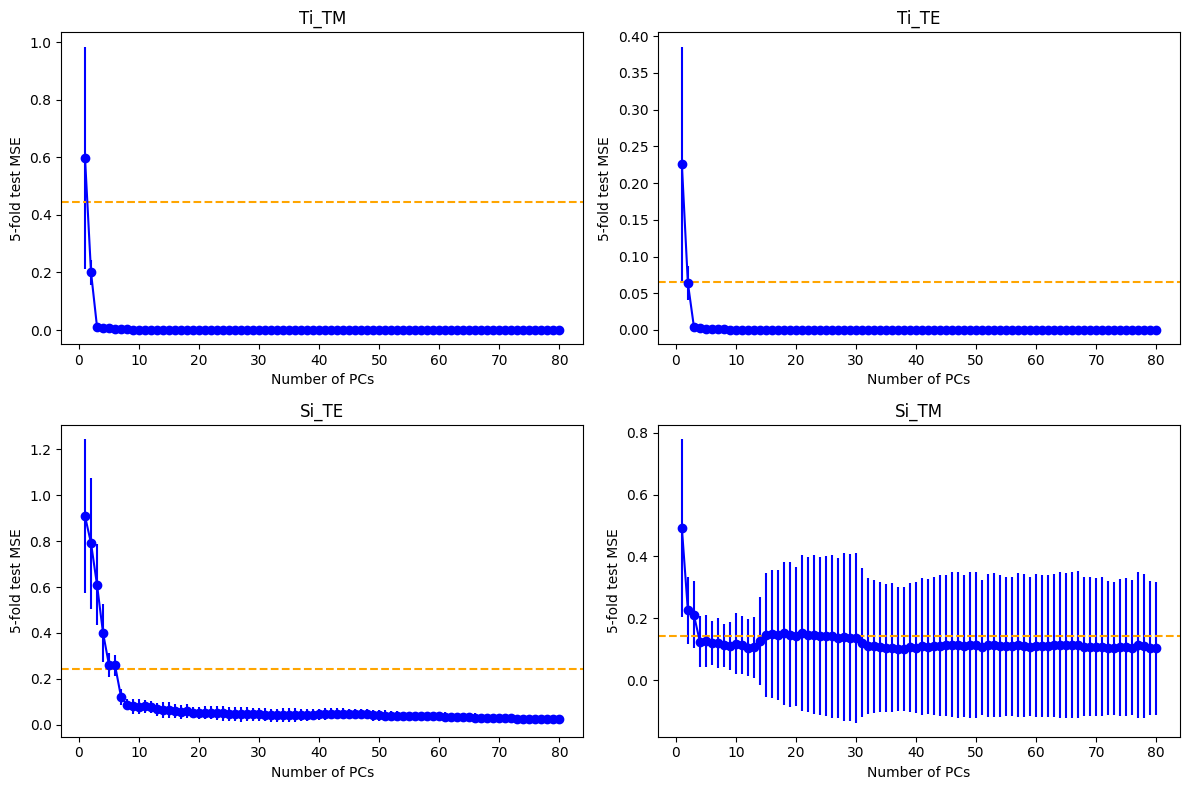

In [21]:
# create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

all_PCs_mean_results = {}

# flatten the axs array for easy indexing
axs = axs.flatten()
# loop through each dataset and plot the results
for i, dat in enumerate(["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]):
    df = pd.DataFrame(nPCs_results_dfs[dat])
    # group by nPCs and calculate the mean and std
    mean_results = df.groupby("nPCs").agg({
        "mse": ["mean", "std"],
        "r2": ["mean", "std"],
        "rmse": ["mean", "std"],
        "mae": ["mean", "std"],
    })
    mean_results.columns = ["_".join(col).strip() for col in mean_results.columns.values]
    all_PCs_mean_results[dat] = mean_results.reset_index()
    # plot a lineplot of nPCs vs mse
    axs[i].errorbar(mean_results.index, mean_results["mse_mean"], yerr=mean_results["mse_std"], label="MSE", fmt='-o', color='blue')
    # set the title to the dataset name
    axs[i].set_title(dat)
    axs[i].set_xlabel("Number of PCs")
    axs[i].set_ylabel("5-fold test MSE")

    # add an orange dashed line for the best feature mse
    best_feat_mse = best_results[dat]["mse_mean"]
    axs[i].axhline(y=best_feat_mse, color='orange', linestyle='--', label="Best Feature MSE")

plt.tight_layout()
plt.show()

This figure shows the change in MSE for each of the 4 datasets as we increase the number of principal components used in the machine learning model with the blue lines. The points represent the mean 5-fold cross-validation hold-out mean-squared error (MSE) across the different principal components used. The vertical bars represent the standard devation in hold-out MSE across the 5 folds for each point. The horizontal orange line represents the mean hold-out MSE when only the best single predictor was used. The PCA model was fit on the training data only (which is why it is capped at only 80 features). The hold-out data was transformed into the PC space generated by the training data. Since PC space is generated without knowledge of the labels. The first principal component may not capture the most relevant dimension to the labels. The order of the PCs reflects the variation explained from the training data. But for the first 3 datasets we can see that the first few PCs capture most of the signal associated with labels and generally outperforms the best single predictor with only marginal improvements in MSE when more PCs are added.

In [18]:
# save the all PCs_mean_results to a xlsx file one to a sheet
with pd.ExcelWriter("all_PCs_mean_results.xlsx") as writer:
    for dat in all_PCs_mean_results.keys():
        all_PCs_mean_results[dat].to_excel(writer, sheet_name=dat, index=False)

# save the actual and fitted values for the best ML model for each dataset

In [28]:
pred_fitted_results_entire_wave_dfs = {}
for dat in ["Ti_TM", "Ti_TE", "Si_TE", "Si_TM"]:
    result_df = None
    fold_i = 0
    for train_data_pca, train_target, test_data_pca, test_target in PC_folds[dat]:
        # now we want to use the entire wave data
        # Fit a linear regression model
        model = LinearRegression()
        model.fit(train_data_pca, train_target)
        # Make predictions
        y_pred = model.predict(test_data_pca)
        
        # now I want to create a dataframe with the true, predicted, and train/test labels
        pred_fitted_test_df = pd.DataFrame({
            "true": test_target,
            f"predicted_fold{fold_i}": y_pred,
            f"train/test_fold{fold_i}": ["test"] * len(test_target),
        })
        # now I want to create a dataframe with the true, predicted, and train/test labels for the training data
        pred_fitted_train_df = pd.DataFrame({
            "true": train_target,
            f"predicted_fold{fold_i}": model.predict(train_data_pca),
            f"train/test_fold{fold_i}": ["train"] * len(train_target),
        })
        # now I want to concatenate the two dataframes
        pred_fitted_df = pd.concat([pred_fitted_train_df, pred_fitted_test_df])
        fold_i += 1
        if result_df is None:
            result_df = pred_fitted_df
        else:
            result_df = result_df.merge(pred_fitted_df, on="true", how="outer")
    pred_fitted_results_entire_wave_dfs[dat] = result_df

In [29]:
# save the pred_fitted_results_entire_wave_dfs to a xlsx file one to a sheet
with pd.ExcelWriter("pred_fitted_results_entire_wave_dfs.xlsx") as writer:
    for dat in pred_fitted_results_entire_wave_dfs.keys():
        pred_fitted_results_entire_wave_dfs[dat].to_excel(writer, sheet_name=dat, index=False)